# Classroom notes and implementations

In this notebook I will include some basic implementations done during
classrooms.

In [7]:
#Includes

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
import time
import pickle

#HOG feature extraction
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn import svm, grid_search
from sklearn.model_selection import train_test_split

%matplotlib inline

In [8]:
#Function which takes an image as input, a list of bounding boxes, color
#tuple and line thickness as inputs then draws boxes in that color on 
#the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img



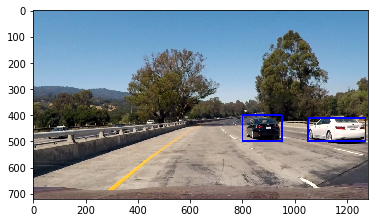

In [9]:
#Testing draw_boxes function

test_img = mpimg.imread('./test_images/test1.jpg')

# Some bounding boxes
bboxes = [((950, 400), (800, 500)), ((1050, 410), (1270, 500))]

result = draw_boxes(test_img, bboxes)
plt.imshow(result)

print()

## 1. Histograms of color

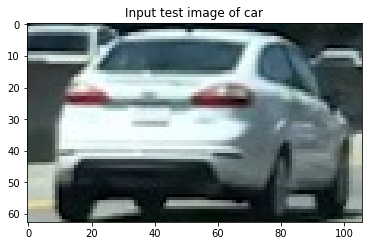

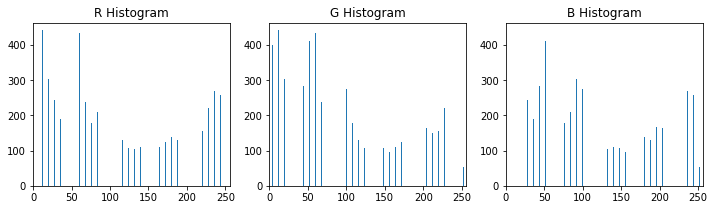

In [10]:
#Reading the test image again

test_img = mpimg.imread('./cutouts/cutout1.jpg')

red_hist = np.histogram(test_img[:,:,0], bins=32, range=(0,256))
green_hist = np.histogram(test_img[:,:,0], bins=32, range=(0,256))
blue_hist = np.histogram(test_img[:,:,0], bins=32, range=(0,256))

#All the histograms have the same number of bins. We only need to compute
#this one time
bin_edges = red_hist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

#Plotting the test image
plt.imshow(test_img)
plt.title("Input test image of car")

#Plotting the histograms
figure = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, red_hist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, green_hist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, blue_hist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

print()

In [11]:
#Histogram features
#Concatenating the histograms of each color channel

hist_features = np.concatenate((red_hist[0], green_hist[0], blue_hist[0]))

In [12]:
#We will define a function in order to automatically compute histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
 

In [13]:
#Function to plot histogram features
def plot_histfeat(histograms, bin_centers, save_out=False, save_name=None):
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    rhist = histograms[0]
    plt.bar(bin_centers, rhist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    
    ghist = histograms[1]
    plt.subplot(132)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    
    bhist = histograms[2]
    plt.subplot(133)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    
    fig.tight_layout()
    
    if save_out:
        fig.savefig('./output_imgs/' + save_name)
    
    plt.show()
    
    return fig

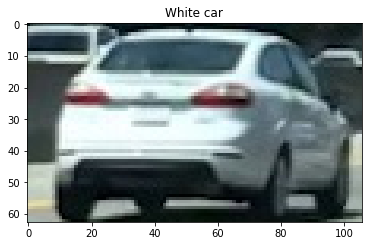

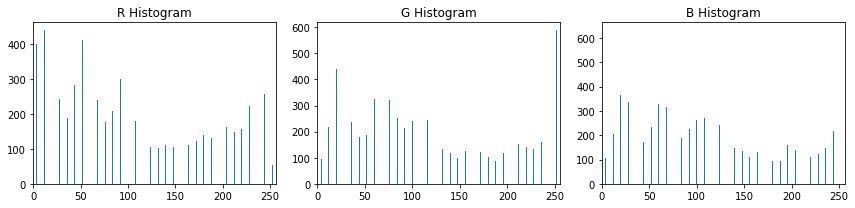

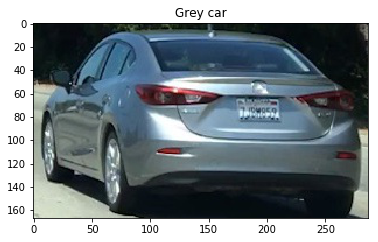

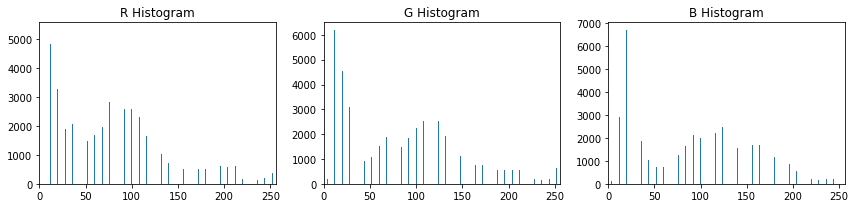

In [14]:
#Testing color_hist function
test_img = mpimg.imread('./cutouts/cutout1.jpg')
test_img1 = mpimg.imread('./cutouts/cutout6.jpg')

rh, gh, bh, bincen, feature_vec = color_hist(test_img, nbins=32, bins_range=(0,256))

plt.imshow(test_img)
plt.title("White car")
figure = plot_histfeat([rh, gh, bh], bincen)


################

rh, gh, bh, bincen, feature_vec = color_hist(test_img1, nbins=32, bins_range=(0,256))

plt.imshow(test_img1)
plt.title("Grey car")
figure = plot_histfeat([rh, gh, bh], bincen)


Looking at the histograms of both cars we can notice some differences in the amount of several colors!

## 2. Explore Color Spaces

In [15]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

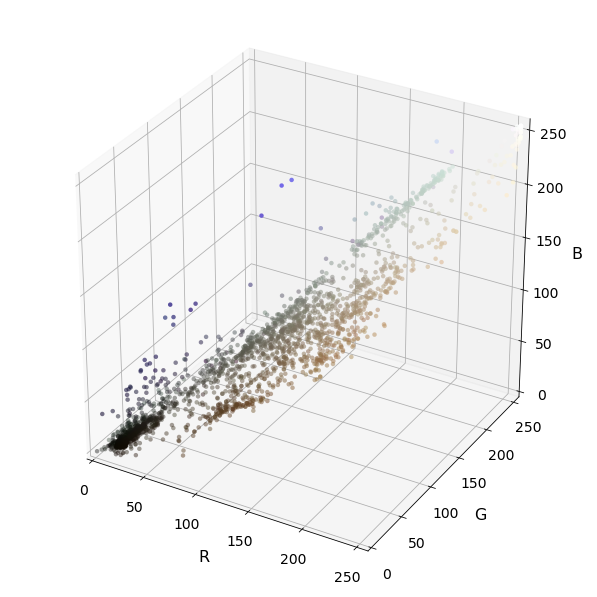

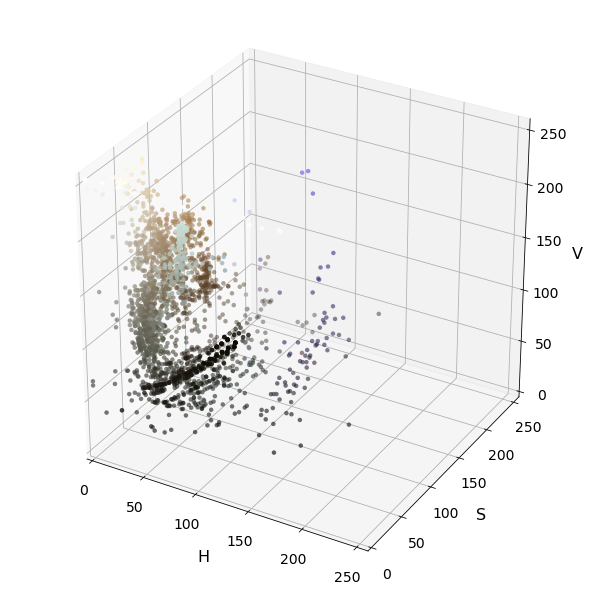

In [16]:
#Testing 3D plots

test_img = mpimg.imread('./cutouts/cutout6.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(test_img.shape[0], test_img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(test_img, (np.int(test_img.shape[1] / scale), np.int(test_img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)


# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

In [17]:
# Function to create a feature vector using a given color space, image and image size

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

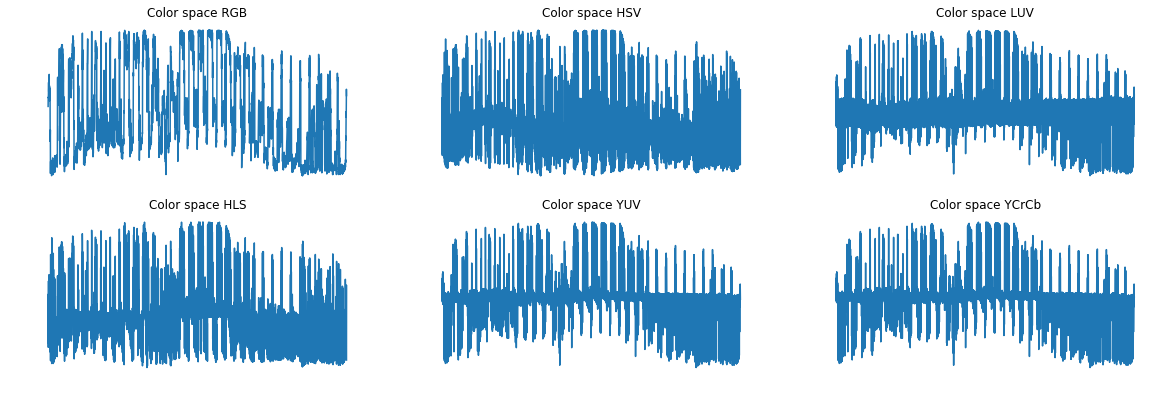

In [18]:
# Testing bin_spatial function

test_img = mpimg.imread('./cutouts/cutout1.jpg')
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']


feature_vectors_test = {}

for space in color_spaces:
    feature_vectors_test[space] = bin_spatial(test_img, color_space=space, size=(32, 32))


figure = plt.figure(figsize= (20,10))
index = 1
for key, featvec in feature_vectors_test.items():
    figure.add_subplot(3,3,index)
    plt.plot(featvec)
    plt.title("Color space {}".format(key))
    plt.axis('off')
    index += 1

## 3. Explore Data

Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8



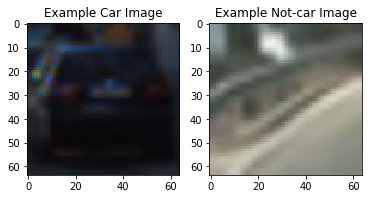

In [19]:
#Read datasets
cars = glob.glob('./dataset/vehicles/**/*.jpeg', recursive=True)
notcars = glob.glob('./dataset/non_vehicles/**/*.jpeg', recursive=True)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict


data_info = data_look(cars, notcars)

print('Your function returned a count of', data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

print()

## 4. Feature Extraction

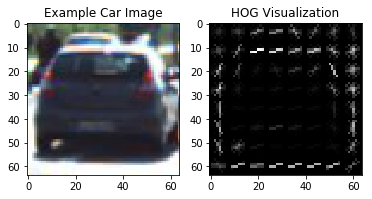

In [20]:
#HOG features

# Define a function to return HOG features and visualization # 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm="L2-Hys")
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm="L2-Hys")
        return features
    
    
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
_, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

print()

### 4.1 Combine and normalize features

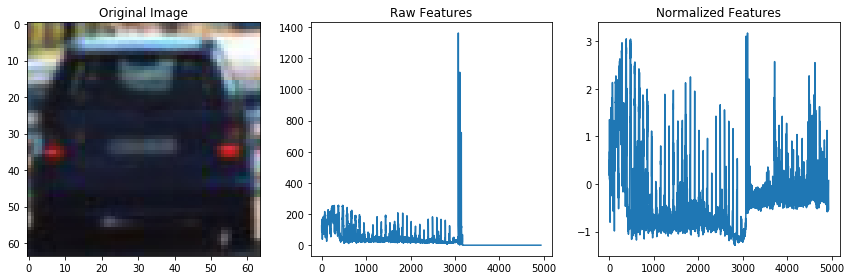

In [21]:
#Read datasets
cars = glob.glob('./dataset/vehicles/**/*.jpeg', recursive=True)
notcars = glob.glob('./dataset/non_vehicles/**/*.jpeg', recursive=True)


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)    
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)    
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features


car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## 5. Training a SVM

In [22]:
#Labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

random_seed = np.random.randint(0, 100)
test_size = 0.2

#Splitting the data into training and validation
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=random_seed)

svc = svm.SVC()

start = time.time()
svc.fit(X_train, y_train)
stop = time.time()
print("SVC was trained with grid search during {} seconds.".format(round(stop-start, 2)))

print('Train accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels: ', y_test[0:10])

pickle.dump(svc, open("./data/svc.p", "wb"))
pickle.dump(X_scaler, open("./data/x_scaler.p", "wb"))

SVC was trained with grid search during 5.83 seconds.
Train accuracy of SVC =  0.9984
Test accuracy of SVC =  0.9914
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  1.  0.  1.  1.]
For labels:  [ 1.  0.  0.  0.  0.  1.  1.  0.  1.  1.]
